# A Large Wind Farm with Complex Geometry

In this notebook, we demonstrate how to use *OptiWindNet* to route cables for a large wind farm with 122 turbines and 2 substations. The site features a concave cable-laying area and includes an internal obstacle.

The added geometric complexity and increased scale have negligible impact on solving time, as they do not increase the number of variables in the MILP optimization model.

In [1]:
from optiwindnet.api import WindFarmNetwork, EWRouter, MILPRouter, ModelOptions, load_repository

In [2]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

### Routers

Using a *MILPRouter* can produce better solutions respect to *EWRouter* and *HGSRouter*. This notebook uses *COIN-OR CBC* as solver, but examples for other solvers (*gurobi, cplex, ortools, scip, highs*) can be found in the *MILPRouter* notebooks.

> Gurobi and IBM ILOG CPLEX are comercial solvers (academic license available). Google's OR-Tools, COIN-OR CBC, SCIP and HiGHS are open-source software.

### Load input data

> Note: the `load_repository()` functionality of *OptiWindNet* is used to load a prebuilt *Networkx.Graph* of the avaible locations. For more details on this functionality look into the notebook about [Load repositories containing location data](a03_load_repositories.ipynb).

In [3]:
locations = load_repository()

The example location from <https://onlinelibrary.wiley.com/doi/abs/10.1049/rpg2.12593> (Taylor_2023) provides suitable specifications for our purpose; a large wind farm with multiple substations and complex geometry.

In [4]:
wfn = WindFarmNetwork(L=locations.taylor_2023, cables=[(5, 100), (8, 200)])

> Note: To view output plots, trust this notebook first.

<Axes: >

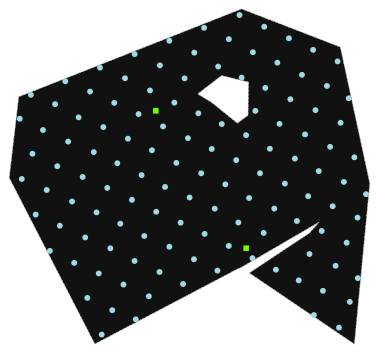

In [5]:
wfn.plot_location()

There are two options for generating an initial solution to warm-start the `MILPRouter`:
- heuristic: `EWRouter()`
- meta-heuristic: `HGSRouter()`

**EWRouter** has the downside of not limiting the number of feeders, thus the model to be warm-started must also have an unlimited number of feeders. This is usually not a problem, as most cable route sets produced by the `MILPRouter` uses the minimum number of feeders or only one more than the minimum.

### Generate the warm-start solution

To generate a warm-start solution, simply run `wfn.optimize()` with the desired solver e.g.:

```python
wfn.optimize(router=warmstart_router)
```

In this example, we use `EWRouter` to warm-start the optimization model. Alternatively, `HGSRouter()` can be used for the same purpose.

The resulting solution is stored within the `wfn` object. The next time `wfn.optimize()` is called, the stored solution (`S` which contains *selected-links*) will be reused as a warm start; provided that the solver in `MILPRouter` supports warm-starting.


In [6]:
warmstart_router = EWRouter()
res_warmstart= wfn.optimize(router=warmstart_router)

In [7]:
wfn.length()

113112.15297348917

### Visualizing the warm-start solution

`S` can be visualized using `wfn.plot_selected_links()`.

> For a detailed explanation and visuals about different graphs and plots in OptiWindNet:
> - look into the notebook about [Plotting](a04_Plotting.ipynb)
> - read this paper:**To be added: \[link to paper]**

<Axes: >

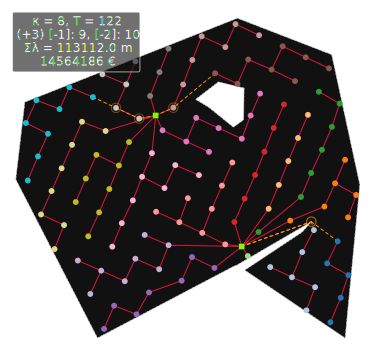

In [8]:
wfn.plot()

### Create an instance of `MILPRouter` and choose COIN-OR Branch and Cut (CBC) as solver.

When initializing a `MILPRouter` three arguments are required to be given:
- solver name
- time limit
- gap

Solver options, including those set by OptiWindNet as well as additional configurable parameters, can be modified by creating a **dictionary** and passing it to the router. The same approach applies to **model options**. For a detailed explanation about model_options and solver_options of MILP routers see the notebook about [ModelOptions vs SolverOptions](a08_ModelOptions.ipynb).

In [9]:
solver_options=dict( # these are in addition to the default solver.options
        # if repeatable results are desired, set the seed
        RandomCbcSeed=1234567,
        # CBC works better if the number threads is set to the number of physical cores
        threads=6,
    )

model_options = ModelOptions(
                        topology='branched',
                        feeder_limit='unlimited',
                        feeder_route='segmented',
                    )

milp_router = MILPRouter(solver_name='cbc', time_limit=30, mip_gap=0.005, solver_options=solver_options, model_options=model_options)

Run optimizatin with MILP router

In [10]:
# Set logging level to INFO to display messages about solver options
import logging
logging.basicConfig(level=logging.INFO)

# run optimization with the milp router (Set verbose=True to display messages about solver progress)
res = wfn.optimize(router=milp_router, verbose=True)

Using warm start: the model is initialized with the provided solution S.



INFO:optiwindnet.MILP.pyomo:>>> cbc solver options <<<
Dins: 'on'
RandomCbcSeed: 1234567
Rens: 'on'
Rins: 'on'
VndVariableNeighborhoodSearch: 'on'
cliqueCuts: 'off'
flowCoverCuts: 'on'
gomoryCuts: 'on'
knapsackCuts: 'off'
liftAndProjectCuts: 'off'
mixedIntegerRoundingCuts: 'on'
nodeStrategy: 'downFewest'
pivotAndComplement: 'off'
probingCuts: 'off'
proximitySearch: 'off'
ratioGap: 0.005
residualCapacityCuts: 'off'
seconds: 30
threads: 6
timeMode: 'elapsed'
twoMirCuts: 'off'
zeroHalfCuts: 'off'



Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: Jan  1 1970 

command line - C:\my_program_files\cbc\bin\cbc.exe -threads 6 -timeMode elapsed -nodeStrategy downFewest -Dins on -VndVariableNeighborhoodSearch on -Rens on -Rins on -pivotAndComplement off -proximitySearch off -gomoryCuts on -mixedIntegerRoundingCuts on -flowCoverCuts on -cliqueCuts off -twoMirCuts off -knapsackCuts off -probingCuts off -zeroHalfCuts off -liftAndProjectCuts off -residualCapacityCuts off -RandomCbcSeed 1234567 -seconds 30 -ratioGap 0.005 -printingOptions all -import C:\Users\amia\AppData\Local\Temp\tmpvp2ixlys.pyomo.lp -mipstart \Users\amia\AppData\Local\Temp\tmpki3t1olj.cbc.soln -stat=1 -solve -solu C:\Users\amia\AppData\Local\Temp\tmpvp2ixlys.pyomo.soln (default strategy 1)
threads was changed from 0 to 6
Option for timeMode changed from cpu to elapsed
Option for nodeStrategy changed from fewest to downfewest
Option for Dins changed from off to on
Option for VndVariableNeighborhoodSearch chang

INFO:optiwindnet.MILP.pyomo:>>> Solution <<<
SolutionInfo(runtime=30.75, bound=104952.14, objective=113017.25676634, relgap=0.07136181674462683, termination='maxTimeLimit')



In [11]:
wfn.G.SolutionInfo

SolutionInfo(runtime=30.75, bound=104952.14, objective=113017.25676634, relgap=0.07136181674462683, termination='maxTimeLimit')

In [12]:
wfn.G.size(weight='length')

113112.15297348917

In [13]:
wfn.length()

113112.15297348917

Terse link of the final layout is returned as output of `wfn.optimize()`. If not assigned to a variable (e.g. res), it can be easily accessed via `wfn.terse_links()`.

In [14]:
res

array([  6,   0,   1,  10,   3,  -2,   5,  14,   7,  10,  11,  20,  -2,
        12,  13,  16,  17,  18,  19,  29,  -2,  14,  31,  15,  25,  26,
        27,  28,  -2,  -2,  -2,  41,  42,  34,  35,  36,  37,  38,  -2,
        -2,  -2,  42,  53,  44,  45,  55,  47,  48,  49,  39,  40,  50,
        64,  54,  66,  67,  68,  69,  59,  49,  -2,  60,  51,  62,  65,
        77,  -1,  68,  81,  70,  83,  59,  60,  61,  73,  63,  75,  78,
        79,  80,  -1,  -1,  -1,  82,  83,  84,  85,  74,  87,  90,  91,
        -1,  -1,  -1,  93,  94,  95,  96,  87, 100, 101,  92,  -1,  94,
       103, 104, 114, 106, 100,  -1, 102, 110, 111, 112, 113, 109, 115,
       121, 117, 118, 116, 120])

### Plot the optimized network graph

>Note: The cable cost is equal to the cable length in this example because no cable price data was provided. As a result, OptiWindNet assigns a unit cost (1.0) per unit length by default.

<Axes: >

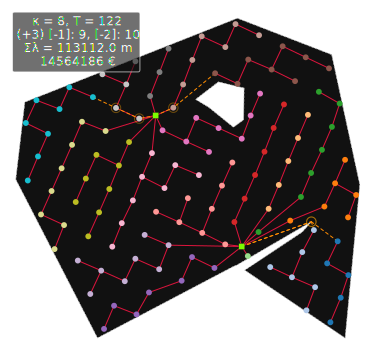

In [15]:
wfn.plot()